# Anomalous Diffusion Driven by Mittag-Leffler Correlated Noise

GenML is a Python library designed for generating Mittag-Leffler correlated noise (abbreviated as M-L noise), which is widely used in modeling complex physical systems. This notebook shows an application of GenML, illustrating the simulation of anomalous diffusion driven by M-L noise, along with the calculation of corresponding mean squared displacement (MSD).<br><br>
First, get started by having all the necessary tools and libraries imported.

In [1]:
import genml
from genml.mittag_leffler import ml

import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

## Parameters

Before diving into the diffusion generation, it's essential to set up some fundamental parameters that define the properties of the noise we intend to generate, such as the number of sequences, length of each sequence, amplitude coefficient, and others.


In [2]:
# Parameters
N = 2000  # Number of sequences
T = 50000  # Length of each sequence
C = 1.0  # Amplitude coefficient
lamda = 1.8  # Mittag-Leffler exponent
tau = 10  # Characteristic memory time
seed = None # Random seed

## Simulating the Anomalous Diffusion Driven by M-L Noise

This section demonstrates the simulation of anomalous diffusion driven by M-L noise, which can be described by the Langevin equation:

$$\frac{{\rm d}x(t)}{{\rm d}t} = \xi (t)$$

We utilize the `mln` API from the GenML library to generate M-L noise sequences. Subsequently, by superimposing the noise sequences along the time dimension, we can obtain the diffusion trajectory $x(t)$ driven by the M-L noise.

In [3]:
# Generate M-L noise sequences
xi = genml.mln(N, T, C, lamda, tau, seed)

M-L Noise Generation Time:  17.48363757133484 s


In [4]:
# Accumulate M-L noise to generate anomalous diffusion
x = np.hstack([np.zeros((xi.shape[0], 1)), np.cumsum(xi, axis=1)])
x = np.array(x)

## Calculation of the Mean Squared Displacement 

MSDs are crucial for understanding the properties of anomalous diffusion. Here we calculate both the actual MSD values from the generated trajectories and the theoretical MSD values.

In [5]:
compute_list = [i for i in range(1, 10)] + [2 * i for i in range(5, 50)] + \
        [10 * i for i in range(10, 100)] + [50 * i for i in range(20, 200)]
compute_list = np.array(compute_list)

- When calculating the actual MSD values, we employ the following equation:

$$ \text{MSD}(t) = \langle |x(t) - x(0)|^2 \rangle $$

where $ \langle \cdot \rangle $ denotes the ensemble average.

- For computing the theoretical MSD values, we use the formula:

$$ \text{MSD}(t) = 2 \int_{0}^{t} (t - s) C(s) \, {\rm d}s $$

Here, $C(s)$ represents the autocorrelation function of M-L noise. Numerical values of the theoretical MSD are obtained through a numerical integration using the composite trapezoidal rule.

In [6]:
# Calculate actual MSD values
msd_cal = []
for i in tqdm(compute_list):
    sd = np.sum((x[:, :-i] - x[:, i:]) ** 2, axis=1) / (T - i)
    msd_cal.append(sd.mean())

  0%|          | 0/324 [00:00<?, ?it/s]

In [7]:
# Function to calculate the autocorrelation values
def CC(s):
    return C * ml(-(abs(s) / tau) ** lamda, alpha=lamda) / (tau ** lamda)

# Function defining the integrand for MSD
def integrand(s, t):
    return (t - s) * CC(s)

# Function to perform composite trapezoidal integration
def integrate_trapezoidal(f, a, b, n):
    h = (b - a) / n
    result = 0.5 * (f(a) + f(b))
    for i in range(1, n):
        result += f(a + i * h)
    result *= h
    return result

# Function to calculate the theoretical MSD
def MSD(t):
    integral_values = [integrate_trapezoidal(lambda s: integrand(s, ti), 0, ti, 5000) for ti in tqdm(t)]
    return 2 * np.array(integral_values)

In [8]:
msd_th = MSD(compute_list)

  0%|          | 0/324 [00:00<?, ?it/s]

### Comparision of actual and theoretical MSDs

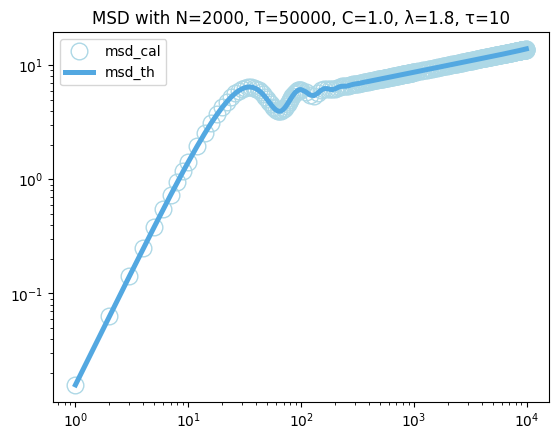

In [9]:
plt.plot(compute_list, msd_cal, 'o', label='msd_cal', color='lightblue', markerfacecolor='none', markersize=12)
plt.plot(compute_list, msd_th, label='msd_th', color='#53A8E1', linewidth=3.6)
plt.title(f'MSD with N={N}, T={T}, C={C}, λ={lamda}, τ={tau}')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()